/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


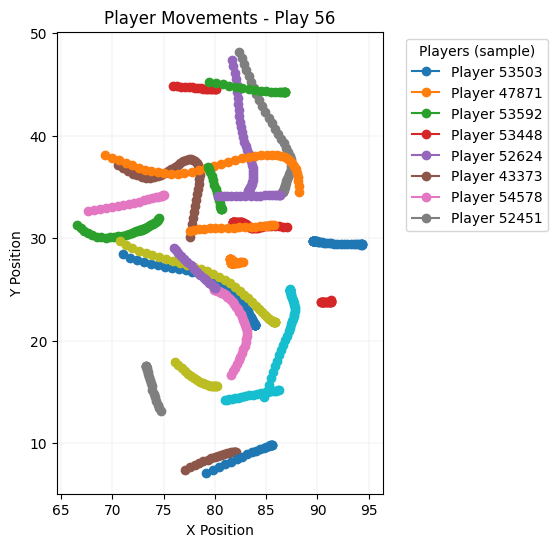

Run type: Interactive


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

RUN_TYPE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "Interactive")
print("Run type:", RUN_TYPE)

sub = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv")
print(sub.head())

# Baseline: predicting 0.0 for all x and y
sub["x"] = 0
sub["y"] = 0

sub.to_csv("/kaggle/working/submission.csv", index = False)
print("Submission file created:", sub.shape)


# Exploration: Visualizing a Single Play
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv")
print(df.head())

# One play_id from dataset
play_id = df['play_id'].iloc[0]
example = df[df['play_id'] == play_id]

# Movement Plotting
plt.figure(figsize = (8, 6))
for pid in example['nfl_id'].unique():
    player_track = example[example['nfl_id'] == pid]
    plt.plot(player_track['x'], player_track['y'], marker = 'o', label = f"Player {pid}")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"Player Movements - Play {play_id}")

# Legend limited to first 8 players
handles, labels = plt.gca().get_legend_handles_labels()
if len(handles) > 8:
    plt.legend(handles[:8], labels[:8], bbox_to_anchor=(1.05, 1), loc='upper left', title="Players (sample)")
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# True to scale distance 
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Padding
x_min, x_max = example['x'].min(), example['x'].max()
y_min, y_max = example['y'].min(), example['y'].max()
ax.set_xlim(x_min - 2, x_max + 2)
ax.set_ylim(y_min - 2, y_max + 2)

plt.grid(True, linewidth=0.3, alpha=0.4)
plt.show()


# Animation: frame-by-frame movement for one play 
import os, numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

RUN_TYPE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "Interactive")
print("Run type:", RUN_TYPE)  

if RUN_TYPE != "Batch":
    # using the same df and play_id already created above
    example = df[df['play_id'] == play_id].copy()
    frame_col = 'frame_id' if 'frame_id' in example.columns else 'frameId'
    example = example.sort_values(frame_col)

    pids = example['nfl_id'].unique()
    pid_to_code = {pid: i for i, pid in enumerate(pids)}
    frames = example[frame_col].unique()

    fig, ax = plt.subplots(figsize = (6, 7))
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_xlabel("X Position"); ax.set_ylabel("Y Position")
    ax.grid(True, linewidth=0.3, alpha=0.4)

    x_min, x_max = example['x'].min(), example['x'].max()
    y_min, y_max = example['y'].min(), example['y'].max()
    ax.set_xlim(x_min - 2, x_max + 2)
    ax.set_ylim(y_min - 2, y_max + 2)

    scat = ax.scatter([], [], s = 30, c = [], cmap = 'tab20', vmin = 0, vmax = max(1, len(pids)-1))

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
        ax.set_title(f"Animated Movement — Play {play_id} | frame …")
        return scat,

    def update(i):
        f = frames[i]
        fdf = example[example[frame_col] == f]
        scat.set_offsets(fdf[['x','y']].values)
        scat.set_array(fdf['nfl_id'].map(pid_to_code).values)
        ax.set_title(f"Animated Movement — Play {play_id} | frame {int(f)}")
        return scat,

    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, interval=100, blit=False)

    html = anim.to_jshtml()
    plt.close(fig)             
    display(HTML(html))        
else:
    print("Skipping animation during Save/Submit run.")

Persistence Baseline - "next (x, y) = last seen (x, y)"
This cell upgrades the zero baseline by predicting each player's next position as their last observed (x, y) in `test_input.csv` for the same `(game_id, play_id, nfl_id)`.


In [2]:
BASE = "/kaggle/input/nfl-big-data-bowl-2026-prediction"

sub = pd.read_csv(f"{BASE}/sample_submission.csv")
test_input = pd.read_csv(f"{BASE}/test_input.csv")

# Parsing
parts = sub["id"].str.split("_", expand = True).astype(int)
parts.columns = ["game_id", "play_id", "nfl_id", "frame_id"]
sub_keys = pd.concat([sub[["id"]], parts], axis = 1)

# Last known position per game, play, and nfl id's. 
last_xy = (
    test_input.sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
        .groupby(["game_id", "play_id", "nfl_id",], as_index = False)
        .tail(1)[["game_id", "play_id", "nfl_id", "x", "y"]]
)

pred = sub_keys.merge(last_xy, on = ["game_id", "play_id", "nfl_id"], how = "left")

# Fallbacks 
mx = test_input["x"].median()
my = test_input["y"].median()
pred.loc[:, "x"] = pred["x"].fillna(mx)
pred.loc[:, "y"] = pred["y"].fillna(my)

pred[["id", "x", "y"]].to_csv("/kaggle/working/submission.csv", index = False)
print("submission.csv written:", pred.shape)

submission.csv written: (5837, 7)


Linear Regression Baseline - Using the last ≤5 frames per player. 

In [3]:
BASE = "/kaggle/input/nfl-big-data-bowl-2026-prediction"

try:
    _ = sub.shape; _ = test_input.shape
except NameError:
    sub = pd.read_csv(f"{BASE}/sample_submission.csv")
    test_input = pd.read_csv(f"{BASE}/test_input.csv")

# Parsing
parts = sub["id"].str.split("_", expand = True).astype(int)
parts.columns = ["game_id", "play_id", "nfl_id", "frame_id"]
sub_keys = pd.concat([sub[["id"]], parts], axis = 1)


fid = "frame_id" if "frame_id" in test_input.columns else "frameId"

# Sorting
ti = test_input.sort_values(["game_id", "play_id", "nfl_id", fid]).copy()

# Taking last up to K frames per (game, play, and player)
K = 5 
lastk = ti.groupby(["game_id", "play_id", "nfl_id"], as_index = False).tail(K)

def fit_group(df):
    f = df[fid].to_numpy(dtype = float)
    x = df["x"].to_numpy(dtype = float)
    y = df["y"].to_numpy(dtype = float)
    if len(df) >= 2:
        bx, ax = np.polyfit(f, x, 1)
        by, ay = np.polyfit(f, y, 1)
    else:
        bx = by = 0.0
        ax = x[-1]; ay = y[-1]
    return pd.Series({"ax": ax, "bx": bx, "ay": ay, "by":  by})

coefs = (
    lastk.groupby(["game_id", "play_id", "nfl_id"])[[fid, "x", "y"]]
    .apply(fit_group)
    .reset_index()
)

#Predicting
pred = sub_keys.merge(coefs, on = ["game_id", "play_id", "nfl_id"], how = "left")
frame = pred["frame_id"].astype(float)
pred["x"] = pred["ax"] + pred["bx"] * frame
pred["y"] = pred["ay"] + pred["by"] * frame

# Fall back and bounds
mx = test_input["x"].median(); my = test_input["y"].median()
pred["x"] = pred["x"].fillna(mx).clip(0, 120)
pred["y"] = pred["y"].fillna(my).clip(0, 53.3)

pred[["id", "x", "y"]].to_csv("/kaggle/working/submissions.csv", index = False)
print("submission.csv written (lin-reg last ≤5 frames):", pred.shape)


submission.csv written (lin-reg last ≤5 frames): (5837, 11)


Offline Validation Procedures 

In [4]:
BASE  = "/kaggle/input/nfl-big-data-bowl-2026-prediction"
fid = "frame_id"

ti = pd.read_csv(f"{BASE}/train/input_2023_w05.csv")
to = pd.read_csv(f"{BASE}/train/output_2023_w05.csv")

# Linear regression baseline 
K = 5 
ti = ti.sort_values(["game_id", "play_id", "nfl_id", fid]).copy()
lastk = ti.groupby(["game_id", "play_id", "nfl_id"], as_index = False).tail(K)

def fit_group(df):
    f = df[fid].to_numpy(float)
    x = df["x"].to_numpy(float)
    y = df["y"].to_numpy(float)
    if len(df) >= 2:
        bx, ax = np.polyfit(f, x, 1)
        by, ay = np.polyfit(f, y, 1)
    else:
        bx = by = 0.0
        ax = x[-1]; ay = y[-1]
    return pd.Series({"ax": ax, "bx": bx, "ay": ay, "by": by})

coefs = (lastk.groupby(["game_id", "play_id", "nfl_id"])[[fid, "x", "y"]]
                .apply(fit_group).reset_index())

pred = to[["game_id", "play_id", "nfl_id", "frame_id"]].merge(
    coefs, on = ["game_id", "play_id", "nfl_id"], how = "left")

frame = pred["frame_id"].astype(float)
pred["x_hat"] = pred["ax"] + pred["bx"] * frame
pred["y_hat"] = pred["ay"] + pred["by"] * frame

# Filling gaps
mx, my = ti["x"].median(), ti["y"].median()
pred["x_hat"] = pred["x_hat"].fillna(mx)
pred["y_hat"] = pred["y_hat"].fillna(my)

# RMSE
dx2 = (to["x"].to_numpy() - pred["x_hat"].to_numpy())**2
dy2 = (to["y"].to_numpy() - pred["y_hat"].to_numpy())**2
rmse = np.sqrt((dx2 + dy2).mean() / 2.0)
print("Offline RMSE (W05):", rmse)

Offline RMSE (W05): 11.370143653243131


Checking Persistence

In [5]:
BASE = "/kaggle/input/nfl-big-data-bowl-2026-prediction"
fid = "frame_id"

def offline_persistence_rmse(week = "w05"):
    ti = pd.read_csv(f"{BASE}/train/input_2023_{week}.csv")
    to = pd.read_csv(f"{BASE}/train/output_2023_{week}.csv")
    last = (ti.sort_values(["game_id", "play_id", "nfl_id", fid])
                .groupby(["game_id", "play_id", "nfl_id"], as_index = False)
                .tail(1)[["game_id", "play_id", "nfl_id", "x", "y"]]
                .rename(columns = {"x":"x_last", "y":"y_last"}))
    pred = to.merge(last, on = ["game_id", "play_id", "nfl_id"], how = "left")
    mx, my = ti["x"].median(), ti["y"].median()
    xh = pred["x_last"].fillna(mx); yh = pred["y_last"].fillna(my)
    rmse = np.sqrt(((to["x"]-xh)**2 + (to["y"]-yh)**2).mean() / 2.0)
    return rmse

print("Offline RMSE (W05) - persistence:", offline_persistence_rmse("w05"))

Offline RMSE (W05) - persistence: 3.9852257156792876


Baseline 2: Constant Velocity
Extending the persistence baseline using the last 2 frames of each player to estimate velocity. 

In [ ]:
rmse_p = offline_persistence_rmse("w05")
rmse_cv = offline_const_velocity_rmse("w05")
print(f"Offline RMSE (W05) - persistence: {rmse_p:.6f}")
print(f"Offline RMSE (W05) - constant velocity: {rmse_cv:.6f}")

In [ ]:
ti, to = load_week("w05")

pid = ti["play_id"].iloc[0]
gid = ti["game_id"].iloc[0]

last_input = ti[(ti["game_id"] ==gid) & (ti["play_id"] ==pid)]["frame_id"].max()
target_frame = to[(to["game_id"] ==gid) & (to["play_id"] ==pid)]["frame_id"].unique()

print("Play:", pid)
print("Last input frame:", last_input)
print("Target frame(s):", target_frame - last_input)

Baseline: Linear Interpolation at Target Relative Frame

In [ ]:
import numpy as np
import pandas as pd

def offline_const_velocity_rmse_tuned(week="w05", max_alpha = 60, step = 0.5, speed_cap_pct = 80):
    
    ti, to = load_week(week)

    # last two frames per (game,play,player)
    lt2 = (ti.sort_values(["game_id","play_id","nfl_id","frame_id"])
             .groupby(["game_id","play_id","nfl_id"])
             .tail(2)[["game_id","play_id","nfl_id","frame_id","x","y"]]
             .reset_index(drop = True))

    # rank 1 = second-last, rank 2 = last
    lt2["rank"] = lt2.groupby(["game_id","play_id","nfl_id"])["frame_id"].rank(method = "first")
    prev_ = lt2[lt2["rank"]==1].rename(columns = {"x":"x_prev","y":"y_prev","frame_id":"frame_prev"})
    last_ = lt2[lt2["rank"]==2].rename(columns = {"x":"x_last","y":"y_last","frame_id":"frame_last"})
    feat = last_.merge(prev_, on=["game_id","play_id","nfl_id"], how ="left")

    # velocity per frame (guard divide-by-zero)
    dt = (feat["frame_last"] - feat["frame_prev"]).clip(lower = 1)
    vx = (feat["x_last"] - feat["x_prev"]) / dt
    vy = (feat["y_last"] - feat["y_prev"]) / dt

    # taming outliers
    speed = np.sqrt(vx**2 + vy**2)
    cap = np.nanpercentile(speed, speed_cap_pct)
    scale = np.minimum(1.0, cap / (speed.replace(0, np.nan)))
    vx = (vx * scale.fillna(1.0)).fillna(0.0)
    vy = (vy * scale.fillna(1.0)).fillna(0.0)

    # joining once for scoring; keeping x_last,y_last aligned to to-rows
    j = to.merge(feat[["game_id","play_id","nfl_id","x_last","y_last"]],
                 on =["game_id","play_id","nfl_id"], how ="left").reset_index(drop = True)

    # grid search α (how many frames to step)
    alphas = np.arange(0, max_alpha + 1e-9, step)
    best_rmse, best_alpha = float("inf"), 0.0
    mx, my = ti["x"].median(), ti["y"].median()

    # broadcasting vx, vy to join's length (safe if ordering matches merges)
    vx_arr = vx.reindex(feat.index).to_numpy()
    vy_arr = vy.reindex(feat.index).to_numpy()

    # mapping from (game,play,nfl) to row index to align vx/vy with j rows
    key = feat[["game_id","play_id","nfl_id"]].astype(str).agg("_".join, axis = 1)
    key_j = j[["game_id","play_id","nfl_id"]].astype(str).agg("_".join, axis = 1)
    
    pos = {k:i for i,k in enumerate(key)}
    idx = key_j.map(pos)

    vxj = pd.Series(vx_arr, index = feat.index).reindex(idx).to_numpy()
    vyj = pd.Series(vy_arr, index = feat.index).reindex(idx).to_numpy()

    for a in alphas:
        x_pred = j["x_last"] + vxj * a
        y_pred = j["y_last"] + vyj * a
        # fallbacks
        x_pred = pd.Series(x_pred).fillna(mx).to_numpy()
        y_pred = pd.Series(y_pred).fillna(my).to_numpy()
        rmse = np.sqrt(((j["x"]-x_pred)**2 + (j["y"]-y_pred)**2).mean())
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, float(a)

    print(f"Offline RMSE ({week}) – CV tuned: {best_rmse:.6f}  (alpha = {best_alpha}, cap = {speed_cap_pct}th)")
    return float(best_rmse), best_alpha



In [ ]:
rmse_p = offline_persistence_rmse("w05")
rmse_cv, alpha = offline_const_velocity_rmse_tuned("w05")
print(f"Offline RMSE (W05) – persistence: {rmse_p:.6f}")
print(f"Offline RMSE (W05) – CV tuned:   {rmse_cv:.6f}  (alpha = {alpha})")


### Baseline Results: W5
- Persistence RMSE: **3.985**
- Tuned Constant-Velocity RMSE: **3.843** (the optimal α ≈ 8.5 frames, capped at 80th percentile speed)

The tuned constant-velocity baseline outperforms persistence by leveraging the average horizon gap and scaling velocity accordingly. 